In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/330k-arabic-sentiment-reviews/arabic_sentiment_reviews.csv


# Load data 

In [2]:
import pandas 
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data="/kaggle/input/330k-arabic-sentiment-reviews/arabic_sentiment_reviews.csv"
df=pd.read_csv(data)

In [4]:
df.head(5)

,label,content
0,1,النعال المريحة: أرتدي هذه النعال كثيرًا!فهي دا...
1,1,منتج جميل ، خدمة سيئة: لقد اشتريت زوجًا من الن...
2,1,جيد للأشياء الصغيرة: هذا يعمل بشكل جيد لالتقاط...
3,0,واهية للغاية: flimsyif للغاية ، فأنت تشتريه ، ...
4,1,Pop for Girls and Girly Boys ، والأشخاص الذين ...


In [5]:
df.tail(5)

,label,content
329995,0,DOA: فتح العلامة التجارية الجديدة من Box.تم تث...
329996,0,شركة صعبة التعامل معها: المنتج كان على ما يرام...
329997,0,SDK Sansa Leather Case: فقير للغاية.لم يتم الإ...
329998,0,حسنًا ، لكن ليس رائعًا: حسنًا ، لقد اشتريت هذا...
329999,1,مريحة جدا!: هذه النعال رائعة!أنها ناعمة جدا وم...


In [6]:
df.isnull().sum()

label      0
content    0
dtype: int64

In [7]:
df.duplicated().sum()

32

In [8]:
df = df.drop_duplicates()

In [9]:
df.duplicated().sum()

0

In [10]:
df.columns

Index(['label', 'content'], dtype='object')

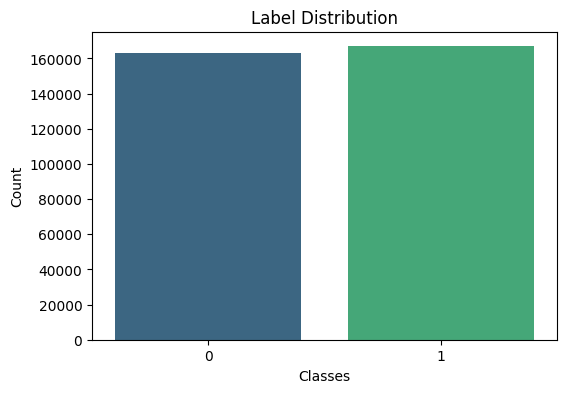

In [11]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df["label"], palette="viridis")
plt.title("Label Distribution")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()

In [12]:
df.shape

(329968, 2)

In [13]:
#df=df.head(1500)

# Split data

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= (train_test_split(
    df["content"],df["label"],test_size=0.3,random_state=42)
)

In [15]:
print(f"Number of train text: {len(X_train)}")
print(f"Number of test text: {len(X_test)}")

Number of train text: 230977
Number of test text: 98991


# BERT

Use a BERT Model to Embed the Data

In [16]:
X_train = X_train.tolist()  
X_test = X_test.tolist()

In [17]:
import numpy as np
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
model_name = "aubmindlab/bert-base-arabertv02"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)


def get_bert_embeddings(texts, max_length=100, batch_size=16):
    all_embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=max_length)
        inputs = {k: v.to("cuda", non_blocking=True) for k, v in inputs.items()}  
        with torch.no_grad():
            outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:,0,:].cpu().numpy()
        all_embeddings.append(embeddings)
    return np.vstack(all_embeddings)


model.to("cuda")  

# Generate embeddings for training and testing data
train_embeddings = get_bert_embeddings(X_train)  # Process full training data
test_embeddings = get_bert_embeddings(X_test)

print(f"Train Embeddings Shape: {train_embeddings.shape}")  
print(f"Test Embeddings Shape: {test_embeddings.shape}")     

tokenizer_config.json:   0%|          | 0.00/381 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/825k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.64M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Train Embeddings Shape: (230977, 768)
Test Embeddings Shape: (98991, 768)


# RNN , LSTM ,BI directions LSTM ,BI directions RNN
We will use TensorFlow/Keras to build and train the classification models.

# RNN model


In [18]:
print(f"X_train shape: {train_embeddings.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (230977, 768)
y_train shape: (230977,)


In [19]:
# Print shapes
print(f"Train Embeddings Shape: {train_embeddings.shape}")  # (num_train_samples, 1, 768)
print(f"Test Embeddings Shape: {test_embeddings.shape}")    # (num_test_samples, 1, 768)


Train Embeddings Shape: (230977, 768)
Test Embeddings Shape: (98991, 768)


In [20]:
print(f"train_embeddings shape: {train_embeddings.shape}")  
print(f"y_train shape: {y_train.shape}")  
print(f"test_embeddings shape: {test_embeddings.shape}")  
print(f"y_test shape: {y_test.shape}")  


train_embeddings shape: (230977, 768)
y_train shape: (230977,)
test_embeddings shape: (98991, 768)
y_test shape: (98991,)


In [21]:
train_embeddings = train_embeddings.reshape(-1, 1, 768)  
test_embeddings = test_embeddings.reshape(-1, 1, 768)  

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 64)                  │          53,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 53,377 (208.50 KB)

 Trainable params: 53,377 (208.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - accuracy: 0.8464 - loss: 0.3595 - val_accuracy: 0.8795 - val_loss: 0.2887
Epoch 2/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8726 - loss: 0.3106 - val_accuracy: 0.8786 - val_loss: 0.2926
Epoch 3/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8736 - loss: 0.3073 - val_accuracy: 0.8805 - val_loss: 0.2852
Epoch 4/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8740 - loss: 0.3046 - val_accuracy: 0.8815 - val_loss: 0.2849
Epoch 5/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.8750 - loss: 0.3016 - val_accuracy: 0.8809 - val_loss: 0.2863
3094/3094 - 3s - 1ms/step - accuracy: 0.8809 - loss: 0.2863
Test Accuracy: 0.8809
3094/3094 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88     48812
           1       0.90      0.86      0.88     50179

    accuracy                         

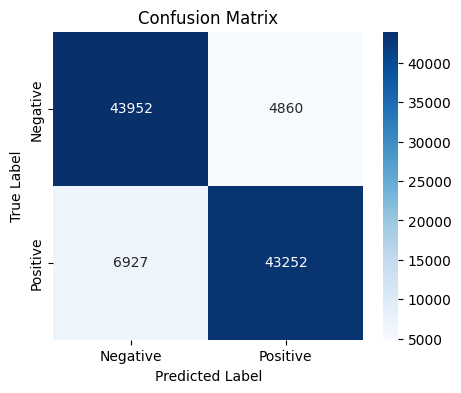

In [22]:
# Build RNN model
from tensorflow.keras.layers import SimpleRNN , Dropout ,Dense
from tensorflow.keras import Sequential 
from tensorflow.keras.metrics import  Accuracy
from sklearn.metrics import classification_report, confusion_matrix


rnn_model = Sequential([
    SimpleRNN(64, input_shape=(1, 768), return_sequences=False),  
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

rnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
rnn_model.summary()

# Train the model
rnn_model.fit(train_embeddings, y_train, epochs=5, batch_size=32, validation_data=(test_embeddings, y_test))

# Evaluate model on test data
rnn_model_loss,rnn_model_accuracy = rnn_model.evaluate(test_embeddings, y_test, verbose=2)
print(f"Test Accuracy: {rnn_model_accuracy:.4f}")

# Generate predictions
y_pred = (rnn_model.predict(test_embeddings) > 0.5).astype("int32")

# Generate classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# LSTM model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │         213,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 213,313 (833.25 KB)

 Trainable params: 213,313 (833.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - accuracy: 0.8550 - loss: 0.3418 - val_accuracy: 0.8807 - val_loss: 0.2830
Epoch 2/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.8731 - loss: 0.3031 - val_accuracy: 0.8823 - val_loss: 0.2820
Epoch 3/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.8768 - loss: 0.2961 - val_accuracy: 0.8802 - val_loss: 0.2816
Epoch 4/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.8770 - loss: 0.2941 - val_accuracy: 0.8841 - val_loss: 0.2744
Epoch 5/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - accuracy: 0.8782 - loss: 0.2914 - val_accuracy: 0.8860 - val_loss: 0.2731
3094/3094 - 5s - 2ms/step - accuracy: 0.8860 - loss: 0.2731
Test Accuracy: 0.8860
3094/3094 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88     48812
           1       0.89      0.88      0.89     50179

    accuracy                         

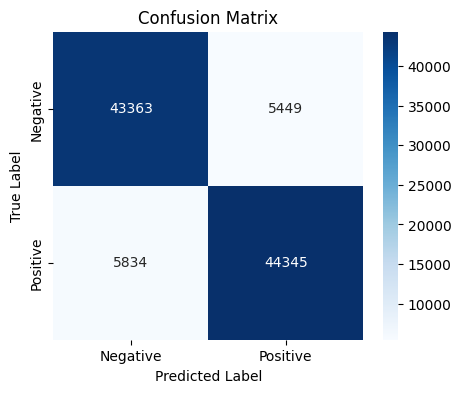

In [23]:
from tensorflow.keras.layers import LSTM , Dense

# Build LSTM model
lstm_model = Sequential([
    LSTM(64, input_shape=(1, 768), return_sequences=False),  
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
lstm_model.summary()

# Train the model
lstm_model.fit(train_embeddings, y_train, epochs=5, batch_size=32, validation_data=(test_embeddings, y_test))

# Evaluate model on test data
lstm_model_loss, lstm_model_accuracy = lstm_model.evaluate(test_embeddings, y_test, verbose=2)
print(f"Test Accuracy: {lstm_model_accuracy:.4f}")

# Generate predictions
y_pred = (lstm_model.predict(test_embeddings) > 0.5).astype("int32")

# Generate classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Bi-Directional RNN model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 128)                 │         106,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 106,753 (417.00 KB)

 Trainable params: 106,753 (417.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step - accuracy: 0.8463 - loss: 0.3588 - val_accuracy: 0.8719 - val_loss: 0.3027
Epoch 2/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8704 - loss: 0.3098 - val_accuracy: 0.8667 - val_loss: 0.3075
Epoch 3/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8714 - loss: 0.3089 - val_accuracy: 0.8797 - val_loss: 0.2884
Epoch 4/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8727 - loss: 0.3065 - val_accuracy: 0.8827 - val_loss: 0.2839
Epoch 5/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step - accuracy: 0.8754 - loss: 0.3023 - val_accuracy: 0.8725 - val_loss: 0.3020
3094/3094 - 3s - 1ms/step - accuracy: 0.8725 - loss: 0.3020
Test Accuracy: 0.8725
3094/3094 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.93      0.88     48812
           1       0.93      0.81      0.87     50179

    accuracy                         

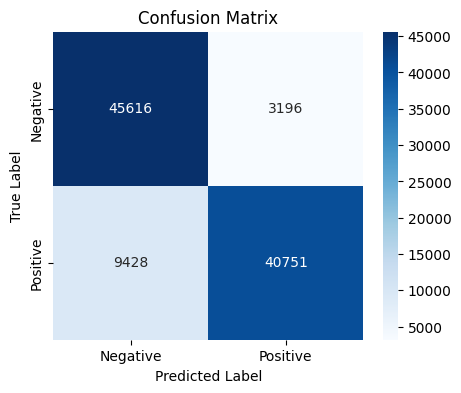

In [24]:
from tensorflow.keras.layers import Bidirectional, SimpleRNN

# Build Bidirectional RNN model
bi_rnn_model = Sequential([
    Bidirectional(SimpleRNN(64, return_sequences=False), input_shape=(1, 768)),  # return_sequences here
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

bi_rnn_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
bi_rnn_model.summary()

# Train the model
bi_rnn_model.fit(train_embeddings, y_train, epochs=5, batch_size=32, validation_data=(test_embeddings, y_test))

# Evaluate model on test data
bi_rnn_model_loss, bi_rnn_model_accuracy = bi_rnn_model.evaluate(test_embeddings, y_test, verbose=2)
print(f"Test Accuracy: {bi_rnn_model_accuracy:.4f}")

# Generate predictions
y_pred = (bi_rnn_model.predict(test_embeddings) > 0.5).astype("int32")

# Generate classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# Bi-Directional LSTM model

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional)      │ (None, 128)                 │         426,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 426,625 (1.63 MB)

 Trainable params: 426,625 (1.63 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - accuracy: 0.8535 - loss: 0.3407 - val_accuracy: 0.8818 - val_loss: 0.2815
Epoch 2/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.8753 - loss: 0.2981 - val_accuracy: 0.8837 - val_loss: 0.2782
Epoch 3/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.8779 - loss: 0.2930 - val_accuracy: 0.8794 - val_loss: 0.2832
Epoch 4/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.8794 - loss: 0.2895 - val_accuracy: 0.8834 - val_loss: 0.2754
Epoch 5/5
7219/7219 ━━━━━━━━━━━━━━━━━━━━ 39s 5ms/step - accuracy: 0.8788 - loss: 0.2903 - val_accuracy: 0.8857 - val_loss: 0.2724
3094/3094 - 6s - 2ms/step - accuracy: 0.8857 - loss: 0.2724
Test Accuracy: 0.8857
3094/3094 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.89      0.88     48812
           1       0.89      0.88      0.89     50179

    accuracy                         

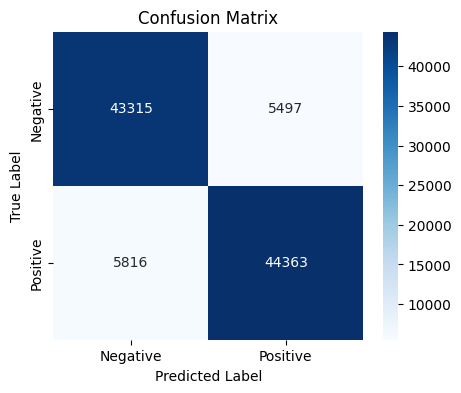

In [25]:
from tensorflow.keras.layers import Bidirectional, LSTM

# Build Bidirectional LSTM model
bi_lstm_model = Sequential([
    Bidirectional(LSTM(64, return_sequences=False), input_shape=(1, 768)),  # return_sequences here
    Dropout(0.5),
    Dense(1, activation="sigmoid")
])

bi_lstm_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
bi_lstm_model.summary()

# Train the model
bi_lstm_model.fit(train_embeddings, y_train, epochs=5, batch_size=32, validation_data=(test_embeddings, y_test))

# Evaluate model on test data
bi_lstm_model_loss, bi_lstm_model_accuracy = bi_lstm_model.evaluate(test_embeddings, y_test, verbose=2)
print(f"Test Accuracy: {bi_lstm_model_accuracy:.4f}")

# Generate predictions
y_pred = (bi_lstm_model.predict(test_embeddings) > 0.5).astype("int32")

# Generate classification report
print("Classification Report:\n", classification_report(y_test, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


# camparison

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


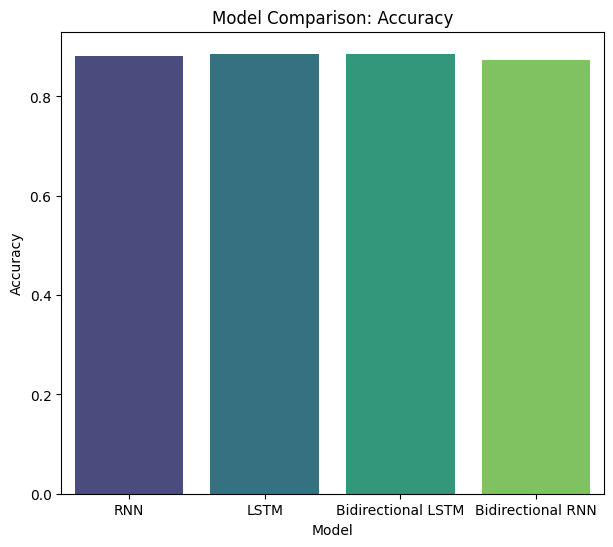

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


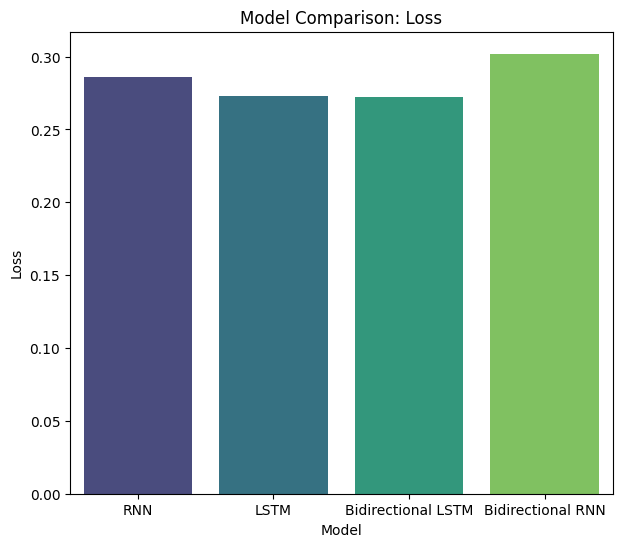

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already trained and evaluated your models, 
# store their accuracy and loss in a dictionary like this:

model_results = {
    'RNN': {'Accuracy': rnn_model_accuracy, 'Loss': rnn_model_loss},
    'LSTM': {'Accuracy': lstm_model_accuracy, 'Loss': lstm_model_loss},
    'Bidirectional LSTM': {'Accuracy': bi_lstm_model_accuracy, 'Loss': bi_lstm_model_loss},
    'Bidirectional RNN': {'Accuracy': bi_rnn_model_accuracy, 'Loss': bi_rnn_model_loss}
}

# Extract model names, accuracies, and losses for plotting
model_names = list(model_results.keys())
accuracies = [model_results[model]['Accuracy'] for model in model_names]
losses = [model_results[model]['Loss'] for model in model_names]

# Visualize accuracy comparison
plt.figure(figsize=(7, 6))
sns.barplot(x=model_names, y=accuracies, palette='viridis')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Model Comparison: Accuracy')
plt.show()

# Visualize loss comparison
plt.figure(figsize=(7, 6))
sns.barplot(x=model_names, y=losses, palette='viridis')
plt.xlabel('Model')
plt.ylabel('Loss')
plt.title('Model Comparison: Loss')
plt.show()
